In [198]:
import numpy as np
import pandas as pd
import itertools

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
import yfinance as yf
import datetime

In [199]:
def stationarity_test(X, cutoff=0.01, print_results=False):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if print_results == True:
        if pvalue < cutoff:
            print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        else:
            pass
            #print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
    else:
        pass
    return pvalue

def cointegration_test(X, Y, cutoff=0.1, print_results=False):
    #Engle-Granger test for cointegration
    score, pvalue, _ = coint(X, Y)
    if print_results == True:
        if pvalue < cutoff:
            print('p-value = ' + str(pvalue) + ' The pair ' + X.name + ' and ' + Y.name + ' is likely cointegrated.')
        else:
            pass
            #print('p-value = ' + str(pvalue) + ' The pair ' + X.name + Y.name + ' is likely not cointegrated.')
    else:
        pass
    return pvalue

In [200]:
stock_list = ['ABEV', "MDLZ", "CAG", "KDP", "KHC", "MNST", "GIS", "K", "MKC", "CCEP", "HRL", "TAP", "IFF", "ADM", "VDC", "XLP", "IYK", "FTXG"]
end_date = pd.Timestamp.today()
start_date =  end_date - pd.Timedelta(days = 365)
df = yf.download(stock_list, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  18 of 18 completed


In [201]:
stock_pairs = list(itertools.combinations(df.columns, 2))
cointegration_results_df = pd.DataFrame(index=range(len(stock_pairs)),columns=['Stock 1', 'Stock 2', 'Coint. P-Value'])

for i, pair in enumerate(stock_pairs):
    df_pairs = df[list(pair)]
    pvalue = cointegration_test(df_pairs[pair[0]], df_pairs[pair[1]], print_results = True)
    cointegration_results_df['Stock 1'][i] = pair[0]
    cointegration_results_df['Stock 2'][i] = pair[1]
    cointegration_results_df['Coint. P-Value'][i] = pvalue

sorted_coint_df = cointegration_results_df.sort_values(by='Coint. P-Value', ascending = True)
print(sorted_coint_df.head(n=10))


p-value = 0.009793185403269499 The pair ABEV and MKC is likely cointegrated.
p-value = 0.07532344702828685 The pair ABEV and VDC is likely cointegrated.
p-value = 0.04092640583980701 The pair CAG and KHC is likely cointegrated.
p-value = 0.032941188050137196 The pair CCEP and KDP is likely cointegrated.
p-value = 0.04745831530915721 The pair FTXG and K is likely cointegrated.
p-value = 0.056336253178357026 The pair IFF and KHC is likely cointegrated.
p-value = 0.01958168168678978 The pair IYK and K is likely cointegrated.
p-value = 0.0021994652513344665 The pair IYK and MKC is likely cointegrated.
p-value = 0.001951083997597206 The pair MDLZ and MNST is likely cointegrated.
    Stock 1 Stock 2 Coint. P-Value
139    MDLZ    MNST       0.001951
112     IYK     MKC       0.002199
12     ABEV     MKC       0.009793
108     IYK       K       0.019582
54     CCEP     KDP       0.032941
41      CAG     KHC       0.040926
66     FTXG       K       0.047458
101     IFF     KHC       0.056336
15

<Axes: xlabel='Date'>

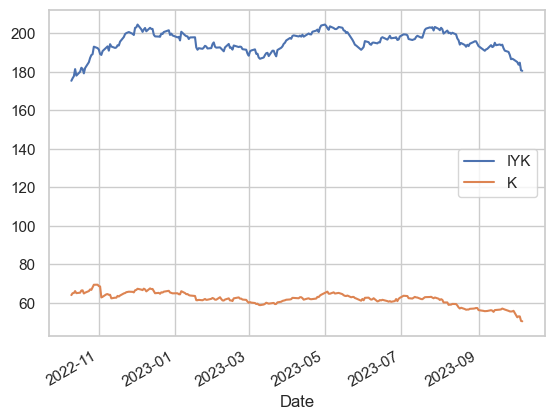

In [202]:
stock_1 = 'IYK'
stock_2 = 'K'

df[[stock_1, stock_2]].plot()

In [203]:
Y = df[stock_1]
X = df[stock_2]
X_with_constant = sm.add_constant(X)
model = OLS(Y, X_with_constant).fit()
spread = Y - model.predict()
spread = spread.rename("Spread")

<Axes: xlabel='Date'>

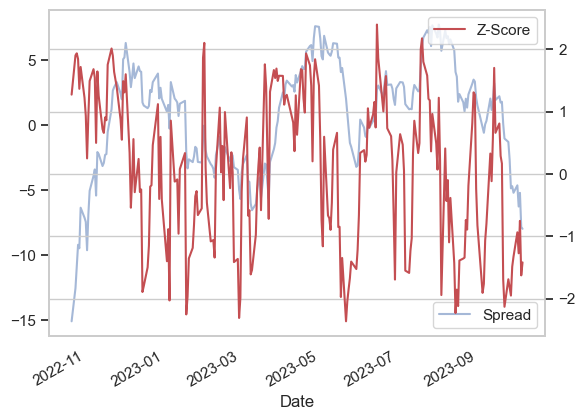

In [204]:
window_size = 10
spread_mean = spread.rolling(window=window_size).mean()
spread_std = spread.rolling(window=window_size).std()
zscore = ((spread - spread_mean)/spread_std)
first_valid_idx = zscore.first_valid_index()
zscore = zscore.rolling(window=1).mean().dropna().rename("Z-Score")

#spread.plot(color='r', alpha=0.5, grid=False)
#ax2 = plt.twinx()
#zscore.plot(ax=ax2, color='b')

plot_df_zscore = pd.merge(spread, zscore, right_index = True, left_index = True)
plot_df_zscore.plot(y='Spread', grid=False, color='b', alpha=0.50)
ax2 = plt.twinx()
plot_df_zscore.plot(y='Z-Score', ax=ax2, color='r')

In [230]:
criteria_list = list()
entry_threshold_list = list()
exit_threshold_list = list()
share_ratios_list = list()

for entry_threshold in np.arange(0.5, 1.4, 0.1):
    for exit_threshold in np.arange (1.5, 2.0, 0.1):
        for share_ratio in np.arange (0.1, 0.9, 0.1):

            stock1_position = pd.Series(data=0, index=zscore.index)
            stock2_position = pd.Series(data=0, index=zscore.index)

            for i in range(1, len(zscore)):
                if zscore.iloc[i] < -entry_threshold and stock1_position.iloc[i-1] == 0:
                    stock1_position.iloc[i] = 1
                    stock2_position.iloc[i] = -1
                elif zscore.iloc[i] > entry_threshold and stock2_position.iloc[i-1] == 0:
                    stock1_position.iloc[i] = -1
                    stock2_position.iloc[i] = 1
                elif abs(zscore.iloc[i]) < exit_threshold:
                    stock1_position.iloc[i] = 0
                    stock2_position.iloc[i] = 0
                else:
                    stock1_position.iloc[i]=stock1_position.iloc[i-1]
                    stock2_position.iloc[i]=stock2_position.iloc[i-1]

            stock1_returns = df[stock_1][first_valid_idx:].pct_change() * stock1_position.shift(1).fillna(0)
            stock2_returns = df[stock_2][first_valid_idx:].pct_change() * stock2_position.shift(1).fillna(0)

            total_returns = share_ratio * stock1_returns + (1-share_ratio) * stock2_returns
            cumulative_returns = (1 + total_returns).cumprod()
            cumulative_returns.iloc[0] = 1

            criterion =  (1 + cumulative_returns.iloc[-1]) / (2 - cumulative_returns.min())
            
            criteria_list.append(criterion)
            entry_threshold_list.append(entry_threshold)
            exit_threshold_list.append(exit_threshold)
            share_ratios_list.append(share_ratio)


In [231]:
strategy_test_df = pd.DataFrame({'Criterion Metric':criteria_list, 'Entry Thresholds':entry_threshold_list, 'Exit Thresholds':exit_threshold_list, 'Share 1 to 2 Ratios':share_ratios_list})
sorted_strategy_df = strategy_test_df.sort_values(by='Criterion Metric', ascending = False)
print(sorted_strategy_df)

     Criterion Metric  Entry Thresholds  Exit Thresholds  Share 1 to 2 Ratios
336          2.211354               1.3              1.7                  0.1
344          2.208384               1.3              1.8                  0.1
328          2.191660               1.3              1.6                  0.1
296          2.189506               1.2              1.7                  0.1
224          2.187582               1.0              1.8                  0.1
..                ...               ...              ...                  ...
8            1.885700               0.5              1.6                  0.1
327          1.882710               1.3              1.5                  0.8
32           1.863155               0.5              1.9                  0.1
295          1.854427               1.2              1.6                  0.8
335          1.852036               1.3              1.6                  0.8

[360 rows x 4 columns]


<Axes: xlabel='Date'>

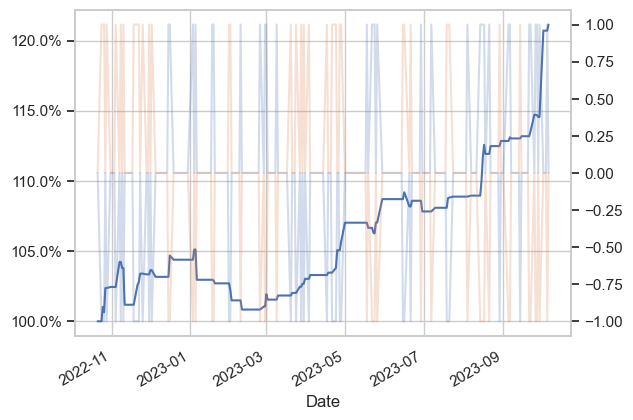

In [235]:
from matplotlib.ticker import PercentFormatter 

entry_threshold = sorted_strategy_df['Entry Thresholds'].iloc[0]
exit_threshold = sorted_strategy_df['Exit Thresholds'].iloc[0]
share_ratio = sorted_strategy_df['Share 1 to 2 Ratios'].iloc[0]

stock1_position = pd.Series(data=0, index=zscore.index)
stock2_position = pd.Series(data=0, index=zscore.index)

for i in range(1, len(zscore)):
    if zscore.iloc[i] < -entry_threshold and stock1_position.iloc[i-1] == 0:
        stock1_position.iloc[i] = 1
        stock2_position.iloc[i] = -1
    elif zscore.iloc[i] > entry_threshold and stock2_position.iloc[i-1] == 0:
        stock1_position.iloc[i] = -1
        stock2_position.iloc[i] = 1
    elif abs(zscore.iloc[i]) < exit_threshold:
        stock1_position.iloc[i] = 0
        stock2_position.iloc[i] = 0
    else:
        stock1_position.iloc[i]=stock1_position.iloc[i-1]
        stock2_position.iloc[i]=stock2_position.iloc[i-1]

stock1_returns = df[stock_1][first_valid_idx:].pct_change() * stock1_position.shift(1).fillna(0)
stock2_returns = df[stock_2][first_valid_idx:].pct_change() * stock2_position.shift(1).fillna(0)

total_returns = share_ratio * stock1_returns + (1-share_ratio) * stock2_returns
cumulative_returns = (1 + total_returns).cumprod()
cumulative_returns.iloc[0] = 1

cumulative_returns = cumulative_returns*100
cumulative_returns.plot().yaxis.set_major_formatter(PercentFormatter())
ax2 = plt.twinx()
stock1_position.plot(ax=ax2, alpha = 0.25, grid = False)
stock2_position.plot(ax=ax2, alpha = 0.25, grid = False)

In [236]:
print(stock1_position.iloc[-1], stock_1)
print(stock2_position.iloc[-1], stock_2)

0 IYK
0 K
